In [1]:
# Experiment 1: Visual Place Recognition with Positive Transformation
# Dataset: GardensPointWalking (day_left vs night_right)
# Feature Descriptors: DELF-HDC
# Descriptor Dimensions: 4096
# Transformation: Positive shift with normalization
# Purpose: Evaluate impact of positive transformation on VPR performance

In [2]:
from scipy.io import loadmat, savemat
from scipy.linalg import orth
import numpy as np
import faiss
from scipy.spatial.distance import cdist
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import gc
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'lib')))

from randn2 import randn2 
import peer_functions as peer
from dot_product import CPUDotProduct, LoihiDotProductSimulationPositive, CPUDotProductPositive
from dot_product import ScaleQuery, ScaleDatabase

import math
from tqdm import tqdm
os.environ['OPENBLAS_NUM_THREADS'] = '1'

c:\Users\21361535\AppData\Local\anaconda3\envs\lava3\lib\site-packages\lava\utils\profiler.py:16: UserWarning: Loihi2HWProfiler could not be imported. Currently no profiler is available.
  warnings.warn("Loihi2HWProfiler could not be imported. "


In [3]:
def calculate_evaluation_metrics(similarity_matrix, ground_truth):
    """
    Calculate evaluation metrics for place recognition results
    
    Args:
        similarity_matrix: Matrix of similarity scores between queries and database
        ground_truth: Ground truth data containing GThard and GTsoft
        
    Returns:
        dict: Dictionary containing recalls, precision, recall curves and AUC
    """
    # Get candidate selections
    ids_pos = peer.directCandSel(similarity_matrix)
    
    # Calculate recall values
    recalls = peer.getRecallAtKVector(ids_pos, ground_truth["GT"])
    
    # Calculate precision-recall curves and AUC
    [R, P] = peer.createPR(-similarity_matrix, 
                          ground_truth['GT']["GThard"][0][0], 
                          ground_truth['GT']["GTsoft"][0][0])
    auc = np.trapz(P, R)
    
    return {
        'recalls': recalls,
        'precision': P,
        'recall': R,
        'auc': auc
    }


In [23]:
D1    = loadmat("../datasets/descriptors/GardensPointWalking/day_left/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
D2    = loadmat("../datasets/descriptors/GardensPointWalking/night_right/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']

g_truth = loadmat("../datasets/ground_truth/GardensPointWalking/day_left--night_right/gt.mat")

In [25]:
dot = CPUDotProduct(D1, D2)

DD = dot.run()

metrics = calculate_evaluation_metrics(DD, g_truth)
print(f"AUC: {metrics['auc']}")

cpu_auc = metrics['auc']


AUC: 0.4702147082864312


## Positive Transformation

In [5]:
constant = 1/math.sqrt(2)

dot = CPUDotProductPositive(D1, D2, constant)


In [6]:
DD = dot.run()

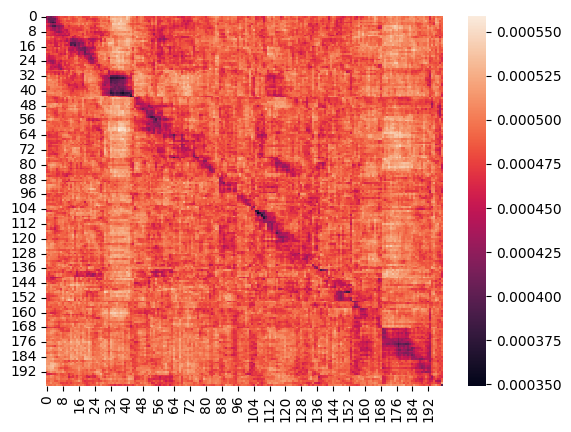

In [7]:
import seaborn as sns

ax = sns.heatmap(DD)
plt.show()

In [8]:

metrics = calculate_evaluation_metrics(DD, g_truth)
print(f"AUC: {metrics['auc']}")

# You can also access other metrics if needed:
# print(f"Recalls: {metrics['recalls']}")
# print(f"Precision: {metrics['precision']}")
# print(f"Recall: {metrics['recall']}")

AUC: 0.4660135714632877


## Loop for multiple positive values


In [17]:
normalizer = Normalizer()

mu1 = np.mean(D1,axis=0)

D1_centered = np.subtract(D1,mu1)  # database
D2_centered = np.subtract(D2,mu1)

D1_norm = normalizer.fit_transform(D1_centered)
D2_norm = normalizer.fit_transform(D2_centered)

In [19]:
min_D1 = np.min(D1_norm)
overall_min = (min_D1)
print(f"Overall min: {overall_min}")


Overall min: -0.09552322839565427


In [20]:
list_positive_values = np.arange(abs(overall_min), 101, 1) 
auc_values = []  # Store AUC values

for positive_value in list_positive_values:
    dot = CPUDotProductPositive(D1, D2, positive_value)
    DD = dot.run()
    metrics = calculate_evaluation_metrics(DD, g_truth)
    auc_values.append(metrics['auc'])
    print(f"AUC: {metrics['auc']}")


AUC: 0.4556737406116905
AUC: 0.46799208645437235
AUC: 0.46827727718830453
AUC: 0.468712987082763
AUC: 0.4682566867187865
AUC: 0.4683367222254081
AUC: 0.4684325000974827
AUC: 0.46835901926007867
AUC: 0.46838473285504273
AUC: 0.46839297567264626
AUC: 0.4683886844583065
AUC: 0.4683298975007593
AUC: 0.46830926217262747
AUC: 0.4682817491241579
AUC: 0.46827984760760233
AUC: 0.4686028521903563
AUC: 0.4686025743436242
AUC: 0.46859869500321716
AUC: 0.4685915595731266
AUC: 0.4685914721325283
AUC: 0.4685903938482078
AUC: 0.46857362758539994
AUC: 0.4685735621271053
AUC: 0.4685735479110834
AUC: 0.46857325089090895
AUC: 0.46857316854067127
AUC: 0.46857318830466094
AUC: 0.4685566855874498
AUC: 0.4685566138321006
AUC: 0.4685566138321006
AUC: 0.46855657979336474
AUC: 0.468557143130469
AUC: 0.4685571293583539
AUC: 0.4685571257329839
AUC: 0.4685571257329839
AUC: 0.4685571051865314
AUC: 0.4685570919789731
AUC: 0.4685570919789731
AUC: 0.4685569776168663
AUC: 0.4685569776168663
AUC: 0.46855697399185436
AUC:

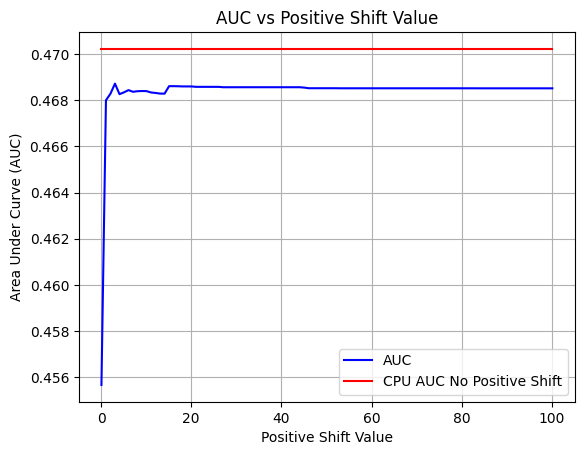

In [27]:
plt.plot(list_positive_values, auc_values, '-b', label='AUC')
plt.plot(list_positive_values, [cpu_auc]*len(list_positive_values), '-r', label='CPU AUC No Positive Shift')
plt.xlabel('Positive Shift Value')
plt.ylabel('Area Under Curve (AUC)')
plt.title('AUC vs Positive Shift Value')
plt.grid(True)
plt.legend()
plt.show()